In [1]:
import spconv.pytorch as spconv
import torch
from torch import nn
from IPython.display import Image
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization.nn.modules.tensor_quantizer import TensorQuantizer

In [ ]:
torch.manual_seed(2024)

# Verification of dense to sparse

In [3]:
spconv3d = spconv.SparseConv3d(
    in_channels=5, 
    out_channels=16, 
    kernel_size=3, 
    stride=1, 
    padding=0,
    bias=False
)

In [4]:
spconv3d.weight.shape

torch.Size([16, 3, 3, 3, 5])

In [5]:
submconv3d = spconv.SubMConv3d(
    in_channels=5, 
    out_channels=16, 
    kernel_size=3, 
    stride=1, 
    padding=0,
    bias=False
)

In [6]:
conv3d = nn.Conv3d(
    in_channels=5, 
    out_channels=16, 
    kernel_size=3, 
    stride=1, 
    padding=0,
    bias=False
)

In [7]:
sp_weight = spconv3d.weight.data.clone()

In [8]:
sp_weight.shape

torch.Size([16, 3, 3, 3, 5])

In [9]:
weight = sp_weight.permute(0, 4, 1, 2, 3)

In [10]:
conv3d.weight.data = weight

In [11]:
conv3d.weight.unique()

tensor([-0.0861, -0.0860, -0.0859,  ...,  0.0860,  0.0860,  0.0860],
       grad_fn=<Unique2Backward0>)

In [12]:
conv3d.to('cuda')
spconv3d.to('cuda')
submconv3d.to('cuda')

SubMConv3d(5, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)

In [13]:
# Parameters
N = 120000  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 3  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 4  # number of batches

In [14]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [15]:
features.shape

torch.Size([120000, 5])

In [16]:
features.unique()

tensor([-4.7913, -4.6806, -4.6266,  ...,  4.5346,  4.6272,  5.1868],
       device='cuda:0')

In [17]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
for i in range(1, ndim + 1):
    indices[:, i] = torch.randint(0, spatial_shape[i - 1], (N,))  # Spatial indices

In [18]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [19]:
x

SparseConvTensor[shape=torch.Size([120000, 5])]

In [20]:
x.features.shape

torch.Size([120000, 5])

In [21]:
x.indices.shape

torch.Size([120000, 4])

In [22]:
# Converting sparse tensor to dense NCHW tensor (just for visualization; might be memory intensive)
x_dense_NCHW = x.dense()
print(x_dense_NCHW.shape)  # Should match the expected dense shape [batch_size, num_channels, *spatial_shape]

torch.Size([4, 5, 100, 100, 100])


In [23]:
x_dense_NCHW = x_dense_NCHW.permute(0, 2, 3, 4, 1)

In [24]:
sparse_tensor = spconv.SparseConvTensor.from_dense(x_dense_NCHW)

In [25]:
x

SparseConvTensor[shape=torch.Size([120000, 5])]

In [26]:
sparse_tensor

SparseConvTensor[shape=torch.Size([118183, 5])]

In [27]:
y = spconv3d(x)
sparse_y = spconv3d(sparse_tensor)

In [28]:
y_dense = y.dense()
sparse_y_dense = sparse_y.dense()

In [29]:
torch.allclose(y_dense, sparse_y_dense)

False

In [30]:
x_dense_NCHW = x_dense_NCHW.permute(0, 4, 1, 2, 3)

In [31]:
conv_y = conv3d(x_dense_NCHW)

In [32]:
torch.allclose(conv_y, sparse_y_dense)

False

In [33]:
conv_y.unique()

tensor([-1.2584, -1.1315, -1.0548,  ...,  1.0731,  1.0758,  1.1631],
       device='cuda:0', grad_fn=<Unique2Backward0>)

In [34]:
sparse_y_dense.unique()

tensor([-1.2582, -1.1315, -1.0547,  ...,  1.0732,  1.0758,  1.1630],
       device='cuda:0', grad_fn=<Unique2Backward0>)

In [22]:
l1loss = torch.nn.L1Loss()

In [36]:
l1loss(conv_y, sparse_y_dense)

tensor(1.6218e-05, device='cuda:0', grad_fn=<MeanBackward0>)

In [37]:
x_dense_NCHW.shape

torch.Size([4, 5, 100, 100, 100])

# Verification of 3D conv implementation of calculation

In [38]:
batch_size, channels, d, h, w = x_dense_NCHW.shape

In [39]:
out_channels, kd, kh, kw, in_channels = spconv3d.weight.shape

In [40]:
dh, dw, dd = spconv3d.stride

In [41]:
print(x_dense_NCHW.shape)

torch.Size([4, 5, 100, 100, 100])


In [42]:
x_dense_NCHW = x_dense_NCHW.unfold(2, kh, dh).unfold(3, kw, dw).unfold(4, kd, dd)

In [43]:
x_dense_NCHW.shape

torch.Size([4, 5, 98, 98, 98, 3, 3, 3])

In [44]:
x_dense_NCHW = x_dense_NCHW.contiguous().view(batch_size, channels, -1, kh, kw, kd)
# x_dense_NCHW = x_dense_NCHW.reshape(batch_size, channels, -1, kh, kw, kd)

In [45]:
print(x_dense_NCHW.shape)

torch.Size([4, 5, 941192, 3, 3, 3])


In [46]:
nb_windows = x_dense_NCHW.size(2)

In [47]:
x_dense_NCHW = x_dense_NCHW.permute(0, 2, 1, 3, 4, 5)

In [48]:
print(x_dense_NCHW.shape)

torch.Size([4, 941192, 5, 3, 3, 3])


In [49]:
filt = conv3d.weight

In [50]:
inputs = x_dense_NCHW.flatten(2)

In [51]:
weight = filt.flatten(1).transpose(0, 1)

In [52]:
inputs = inputs.view(-1, inputs.shape[-1])

In [53]:
print(inputs.shape)
print(weight.shape)

torch.Size([3764768, 135])
torch.Size([135, 16])


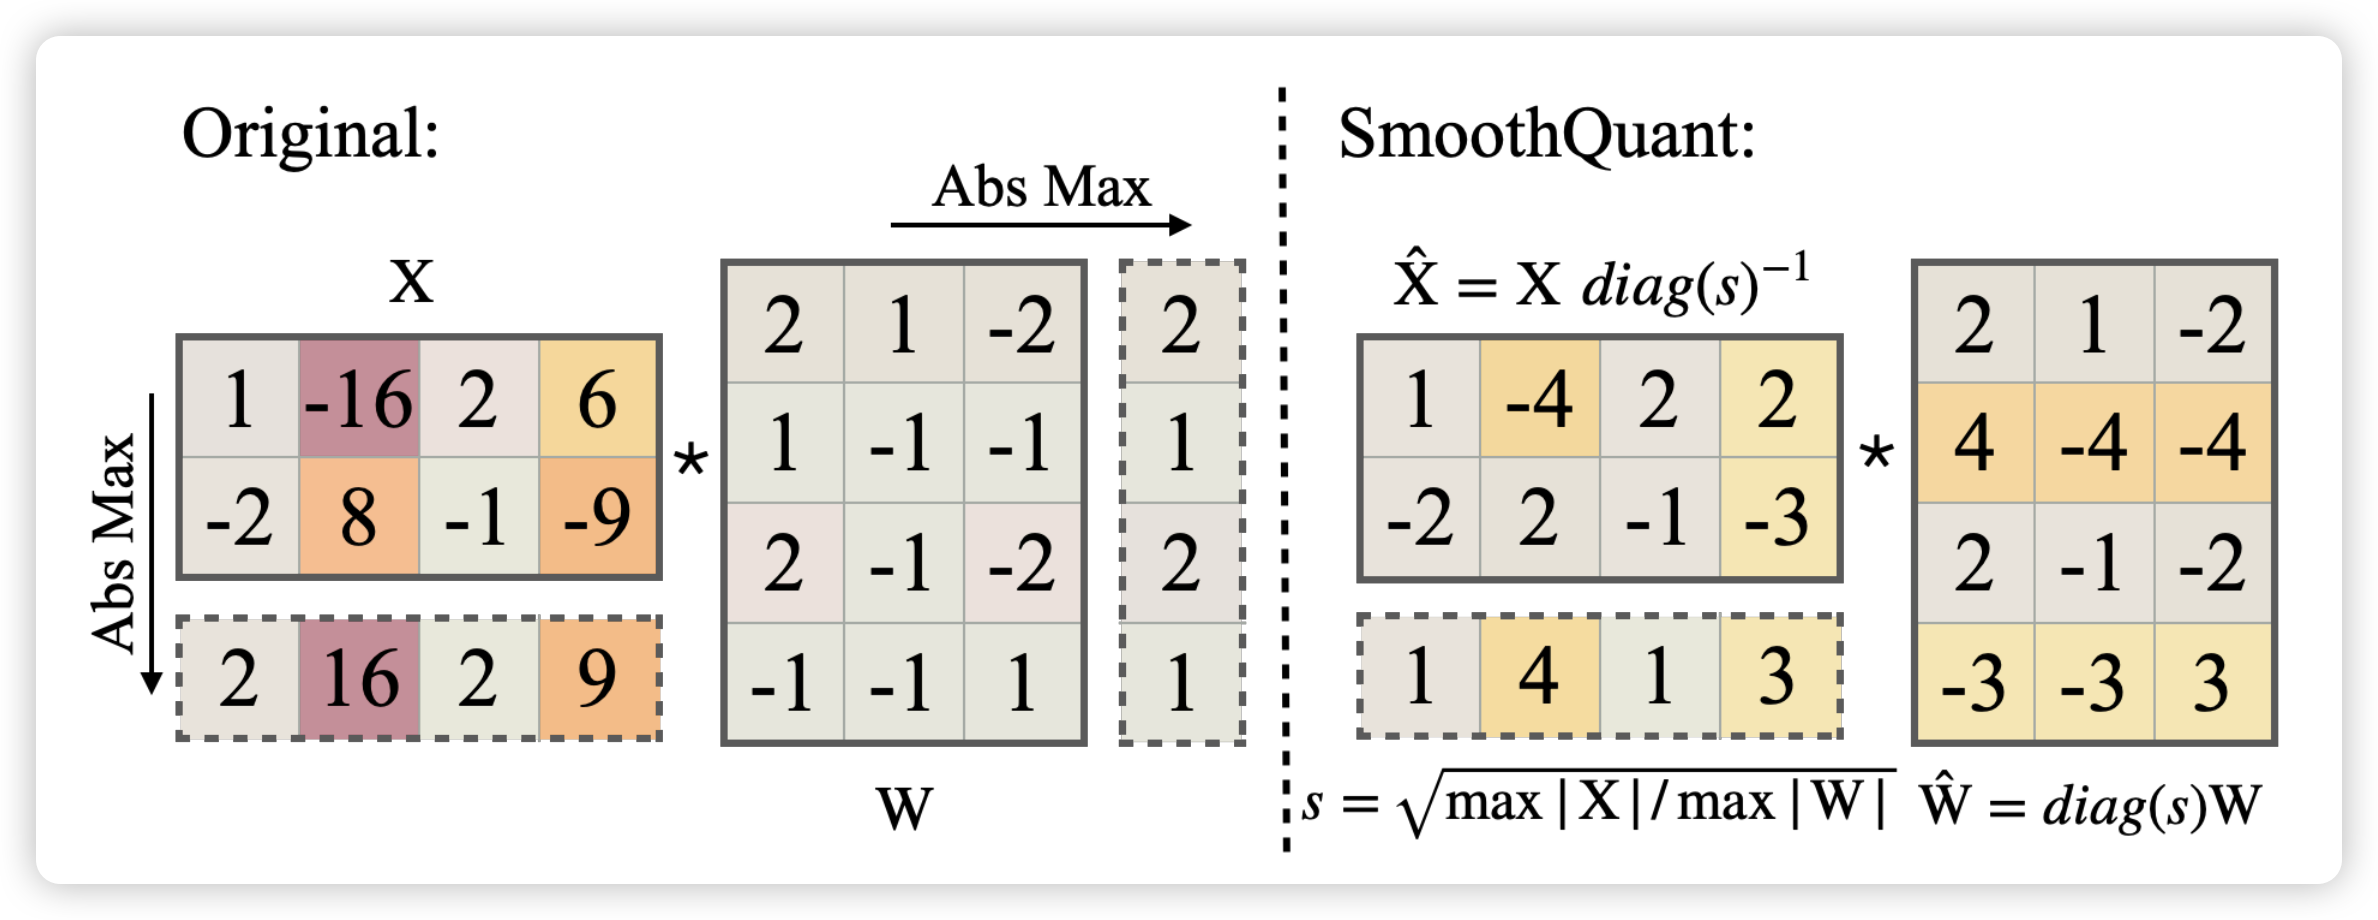

In [54]:
Image('iShot_2024-06-13_20.12.25.png')

In [55]:
my_res = inputs @ weight

In [56]:
activation_descriptor = QuantDescriptor(
    num_bits=8,
    # unsigned=True
)
weight_descriptor = QuantDescriptor(
    num_bits=8, 
    axis=(0)
)

In [57]:
input_quantizer = TensorQuantizer(activation_descriptor)
weight_quantizer = TensorQuantizer(weight_descriptor)

In [58]:
tensorr_weight_t = weight.t()
quantized_inputs = input_quantizer(inputs)
quantized_weight = weight_quantizer(tensorr_weight_t).t()
my_quantized_res = quantized_inputs @ quantized_weight

In [59]:
l1loss(quantized_inputs, inputs)

tensor(0.0003, device='cuda:0')

In [60]:
l1loss(quantized_weight, tensorr_weight_t.t())

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

In [61]:
tensorr_weight_t.unique().shape

torch.Size([2160])

In [62]:
quantized_weight.unique().shape

torch.Size([1687])

In [63]:
tensor_inputs = inputs.abs().detach()
tensor_weight = weight.abs().detach()
tensor_weight_t = tensor_weight.t()
weight_t = weight.t()
act_scale = torch.max(tensor_inputs, dim=0)[0]
weight_scale = torch.max(tensor_weight_t, dim=0)[0]
scaling_factor = 0.90
scale = act_scale**scaling_factor/weight_scale**(1-scaling_factor)
scale[scale==0] = 1
inputs /= scale
weight_t *= scale
quantized_sq_inputs = input_quantizer(inputs)
quantized_sq_weight = weight_quantizer(weight_t).t()
# quantized_sq_weight = weight_t.t() # comment out
my_quantized_sq_res = quantized_sq_inputs @ quantized_sq_weight

In [64]:
scale.unique()

tensor([4.8961, 4.9001, 4.9019, 4.9050, 4.9053, 4.9098, 4.9105, 4.9108, 4.9122,
        4.9124, 4.9129, 4.9133, 4.9137, 4.9138, 4.9147, 4.9184, 4.9243, 4.9256,
        4.9274, 4.9296, 4.9323, 4.9468, 4.9509, 4.9569, 4.9708, 5.0166, 5.0294,
        5.0729, 5.0731, 5.0733, 5.0733, 5.0737, 5.0767, 5.0793, 5.0794, 5.0818,
        5.0822, 5.0838, 5.0841, 5.0842, 5.0846, 5.0849, 5.0882, 5.0891, 5.0903,
        5.0910, 5.0913, 5.0926, 5.0946, 5.0995, 5.1026, 5.1027, 5.1029, 5.1036,
        5.1074, 5.1078, 5.1093, 5.1134, 5.1135, 5.1136, 5.1168, 5.1180, 5.1207,
        5.1231, 5.1251, 5.1252, 5.1335, 5.1347, 5.1357, 5.1358, 5.1363, 5.1388,
        5.1397, 5.1456, 5.1556, 5.1594, 5.1677, 5.1754, 5.2215, 5.2363, 5.2371,
        5.2373, 5.2387, 5.2400, 5.2401, 5.2416, 5.2450, 5.2468, 5.2473, 5.2555,
        5.2560, 5.2560, 5.2600, 5.2633, 5.2636, 5.2684, 5.2716, 5.2729, 5.2732,
        5.2739, 5.2757, 5.2867, 5.2872, 5.2949, 5.3157, 5.3176, 5.3638, 5.3716,
        5.6229, 5.6276, 5.6284, 5.6287, 

In [65]:
weight_t.unique().shape

torch.Size([2160])

In [66]:
quantized_sq_weight.unique().shape

torch.Size([1680])

In [67]:
l1loss(quantized_sq_inputs, inputs)

tensor(5.3595e-05, device='cuda:0')

In [68]:
l1loss(quantized_sq_weight, weight)

tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)

In [69]:
weight_t.unique().shape

torch.Size([2160])

In [70]:
quantized_sq_weight.unique().shape

torch.Size([1680])

In [71]:
act_scale.shape

torch.Size([135])

In [72]:
weight_scale.shape

torch.Size([135])

In [73]:
my_res = my_res.view(batch_size, -1, my_res.shape[-1])
my_quantized_res = my_quantized_res.view(batch_size, -1, my_res.shape[-1])
my_quantized_sq_res = my_quantized_sq_res.view(batch_size, -1, my_res.shape[-1])

In [74]:
my_res = my_res.transpose(1, 2)
my_quantized_res = my_quantized_res.transpose(1, 2)
my_quantized_sq_res = my_quantized_sq_res.transpose(1, 2)

In [75]:
my_res = my_res.unflatten(2, (h - 2*dh, w - 2*dw, d - 2*dd))
my_quantized_res = my_quantized_res.unflatten(2, (h - 2*dh, w - 2*dw, d - 2*dd))
my_quantized_sq_res = my_quantized_sq_res.unflatten(2, (h - 2*dh, w - 2*dw, d - 2*dd))

In [76]:
print(my_res.shape)
print(my_quantized_res.shape)
print(my_quantized_sq_res.shape)

torch.Size([4, 16, 98, 98, 98])
torch.Size([4, 16, 98, 98, 98])
torch.Size([4, 16, 98, 98, 98])


In [77]:
standard_res = conv3d(x.dense())

#### L1Loss between my implementation of conv3d and the true one

In [78]:
l1loss(my_res, standard_res)

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

#### L1Loss between my implementation of quantized conv3d and the true one without SQ

In [79]:
l1loss(my_quantized_res, standard_res)

tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)

#### L1Loss between my implementation of quantized conv3d and the true one with the application of SQ

In [80]:
l1loss(my_quantized_sq_res, standard_res)

tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)

In [81]:
!nvidia-smi

Mon Jul  1 03:32:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:85:00.0 Off |                    0 |
| N/A   32C    P0              94W / 400W |  20396MiB / 40960MiB |      5%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# L1 loss creation

In [3]:
l1loss = torch.nn.L1Loss()

# Layer creation

In [4]:
spconv3d = spconv.SparseConv3d(
    in_channels=5, 
    out_channels=16, 
    kernel_size=3, 
    stride=1, 
    padding=0,
    bias=False
)

In [5]:
submconv3d = spconv.SubMConv3d(
    in_channels=5, 
    out_channels=16, 
    kernel_size=3, 
    stride=1, 
    padding=0,
    bias=False
)

In [6]:
spconv3d.to('cuda')
submconv3d.to('cuda')

SubMConv3d(5, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)

# Simple verification of global SmoothQuant of sparseconv3d

In [7]:
# Parameters
N = 120000  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 3  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 4  # number of batches

In [8]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [9]:
features.shape

torch.Size([120000, 5])

In [10]:
features.unique()

tensor([-4.7913, -4.6806, -4.6266,  ...,  4.5346,  4.6272,  5.1868],
       device='cuda:0')

In [11]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
for i in range(1, ndim + 1):
    indices[:, i] = torch.randint(0, spatial_shape[i - 1], (N,))  # Spatial indices

In [12]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [13]:
x

SparseConvTensor[shape=torch.Size([120000, 5])]

In [14]:
x.features

tensor([[-1.0165, -0.6119,  0.1257, -0.2585,  0.2442],
        [-0.2137, -0.5030, -0.5165, -1.0676, -0.8075],
        [ 0.3336, -1.3717, -2.1233, -0.1856, -0.6183],
        ...,
        [-0.6652, -1.3503, -0.5237, -0.7438, -0.9998],
        [ 0.6097, -0.3261,  0.0637, -0.3798, -1.6436],
        [ 0.2590,  0.4437,  0.3290,  2.0755, -1.9294]], device='cuda:0')

In [15]:
y = spconv3d(x)

In [16]:
y

SparseConvTensor[shape=torch.Size([2090391, 16])]

In [17]:
spconv3d.weight.data = spconv3d.weight.data * 2
features = x.features
features /= 2
x.replace_feature(features)
my_y = spconv3d(x)

In [18]:
l1loss(y.features, my_y.features)

tensor(0.1470, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
y.features

tensor([[ 0.1298,  0.0695,  0.0415,  ...,  0.0121, -0.1049,  0.0306],
        [-0.1746,  0.1543, -0.1796,  ..., -0.2211, -0.0533, -0.1065],
        [ 0.1362,  0.0518, -0.0253,  ...,  0.0724, -0.0927,  0.0552],
        ...,
        [-0.0389,  0.0186,  0.2587,  ...,  0.0219,  0.0548, -0.0250],
        [-0.0902, -0.0266, -0.0176,  ..., -0.0835, -0.0322, -0.0697],
        [ 0.0156, -0.1141, -0.0551,  ..., -0.1034, -0.0742, -0.0368]],
       device='cuda:0', grad_fn=<SparseImplicitGemmFunctionBackward>)

In [20]:
my_y.features

tensor([[ 0.1298,  0.0695,  0.0415,  ...,  0.0121, -0.1049,  0.0306],
        [-0.1746,  0.1543, -0.1796,  ..., -0.2211, -0.0533, -0.1065],
        [ 0.1362,  0.0518, -0.0253,  ...,  0.0724, -0.0927,  0.0552],
        ...,
        [-0.1678,  0.1967,  0.0375,  ...,  0.0106, -0.6322,  0.2996],
        [-0.1054, -0.0428, -0.1233,  ..., -0.0384, -0.1039, -0.0016],
        [-0.0389, -0.0216, -0.0175,  ..., -0.0753,  0.0124, -0.0239]],
       device='cuda:0', grad_fn=<SparseImplicitGemmFunctionBackward>)

# Simple verification of global SmoothQuant of submconv3d

In [21]:
# Parameters
N = 120000  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 3  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 4  # number of batches

In [22]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [23]:
features.shape

torch.Size([120000, 5])

In [24]:
features.unique()

tensor([-4.6082, -4.5447, -4.4877,  ...,  4.5561,  4.6069,  4.6144],
       device='cuda:0')

In [25]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
for i in range(1, ndim + 1):
    indices[:, i] = torch.randint(0, spatial_shape[i - 1], (N,))  # Spatial indices

In [26]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [27]:
x

SparseConvTensor[shape=torch.Size([120000, 5])]

In [28]:
x.features

tensor([[-0.4551,  1.0078, -0.4453,  0.2257,  0.7234],
        [ 1.6856,  0.2254, -0.0980, -0.7227, -0.2667],
        [ 0.9519,  0.0864, -0.3306, -2.3476,  0.7939],
        ...,
        [-0.5672, -0.1766, -0.0841,  1.7915, -0.8765],
        [-0.9534, -0.0085,  0.0356, -0.2929,  1.0164],
        [-0.1921, -1.9698,  0.5773,  0.2719, -0.2404]], device='cuda:0')

In [29]:
y = submconv3d(x)

In [30]:
y

SparseConvTensor[shape=torch.Size([120000, 16])]

In [31]:
spconv3d.weight.data = spconv3d.weight.data * 2
features = x.features
features /= 2
x.replace_feature(features)
my_y = submconv3d(x)

In [32]:
l1loss(y.features, my_y.features)

tensor(0.0585, device='cuda:0', grad_fn=<MeanBackward0>)

In [33]:
y.features

tensor([[ 0.1095,  0.0869, -0.1023,  ...,  0.0228,  0.0834,  0.0492],
        [-0.1162, -0.0589, -0.0288,  ...,  0.0430,  0.1393, -0.0942],
        [ 0.0364, -0.0562,  0.0829,  ...,  0.1630,  0.2089,  0.0194],
        ...,
        [-0.0467,  0.0355, -0.0959,  ..., -0.0787, -0.2017, -0.1361],
        [ 0.1303,  0.0187,  0.0581,  ...,  0.0140,  0.0295,  0.1591],
        [-0.0102, -0.0949,  0.2403,  ..., -0.0467, -0.2155,  0.1132]],
       device='cuda:0', grad_fn=<SparseImplicitGemmFunctionBackward>)

In [34]:
my_y.features

tensor([[ 0.0547,  0.0435, -0.0512,  ...,  0.0114,  0.0417,  0.0246],
        [-0.0581, -0.0295, -0.0144,  ...,  0.0215,  0.0696, -0.0471],
        [ 0.0182, -0.0281,  0.0415,  ...,  0.0815,  0.1044,  0.0097],
        ...,
        [-0.0234,  0.0178, -0.0480,  ..., -0.0394, -0.1008, -0.0681],
        [ 0.0652,  0.0093,  0.0290,  ...,  0.0070,  0.0148,  0.0796],
        [-0.0051, -0.0475,  0.1202,  ..., -0.0233, -0.1077,  0.0566]],
       device='cuda:0', grad_fn=<SparseImplicitGemmFunctionBackward>)

# Verification of global Smoothquant of sparseconv3d

In [35]:
# Parameters
N = 120000  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 3  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 4  # number of batches

In [36]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [37]:
features.shape

torch.Size([120000, 5])

In [38]:
features.unique()

tensor([-4.7846, -4.5039, -4.4555,  ...,  4.4866,  4.6958,  4.7309],
       device='cuda:0')

In [39]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
for i in range(1, ndim + 1):
    indices[:, i] = torch.randint(0, spatial_shape[i - 1], (N,))  # Spatial indices

In [40]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [41]:
x

SparseConvTensor[shape=torch.Size([120000, 5])]

In [42]:
x.features

tensor([[-1.5808e+00,  1.2555e+00, -2.1358e-02, -4.7948e-01, -6.8748e-02],
        [-1.8406e+00, -5.2259e-01,  7.2286e-01,  8.4376e-01,  5.9045e-01],
        [ 1.3201e+00, -3.0493e-01,  1.0602e-03,  1.2127e-01,  7.8455e-02],
        ...,
        [ 3.1526e-01, -2.2720e-01,  1.9170e+00,  3.2581e-01,  2.5783e-01],
        [-1.7980e-01, -4.0181e-01, -5.2056e-01, -4.6544e-01, -3.0503e-01],
        [ 6.0693e-01,  5.8779e-01, -6.5974e-01,  1.1842e-01,  1.0833e+00]],
       device='cuda:0')

In [43]:
y = spconv3d(x)

In [44]:
y

SparseConvTensor[shape=torch.Size([2086466, 16])]

In [45]:
w_desc = QuantDescriptor(
            num_bits=8, 
            axis=(0)
        )
w_quant = TensorQuantizer(w_desc)

act_desc = QuantDescriptor(
            num_bits=8
        )
act_quant = TensorQuantizer(act_desc)

In [46]:
features = x.features

features_max = features.abs().max()
weight_max = spconv3d.weight.data.abs().max()

scale = torch.sqrt(features_max/weight_max)

features /= scale
features = act_quant(features)
x.replace_feature(features)

oc, kh, kw, kd, ic = spconv3d.weight.data.shape
w = spconv3d.weight.data.permute(0, 4, 1, 2, 3).contiguous().view(oc, -1)
w *= scale
w = w_quant(w)
spconv3d.weight.data = w.view(oc, ic, kh, kw, kd).permute(0, 2, 3, 4, 1).contiguous()

my_y = spconv3d(x)

In [47]:
my_y.features.shape

torch.Size([2086466, 16])

In [48]:
l1loss(y.features, my_y.features)

tensor(0.5883, device='cuda:0', grad_fn=<MeanBackward0>)

In [49]:
y.features

tensor([[-0.2697, -0.6426, -0.8264,  ...,  1.0776, -0.8160, -0.8146],
        [-0.2002,  0.3343,  0.5090,  ...,  0.2324,  0.1244,  0.4530],
        [-0.5413, -0.1418, -0.1121,  ..., -0.4699,  0.9533, -0.2922],
        ...,
        [ 0.0297, -0.0082, -0.0608,  ...,  0.0226,  0.0988, -0.1726],
        [-0.1028, -0.2766, -0.5025,  ..., -0.2058,  0.9071,  0.3307],
        [ 1.0760, -0.8067, -0.0985,  ..., -0.8686,  0.5486, -0.4605]],
       device='cuda:0', grad_fn=<SparseImplicitGemmFunctionBackward>)

In [50]:
my_y.features

tensor([[-1.1025, -0.4383, -0.1897,  ...,  0.6281,  0.4973, -0.2121],
        [-0.5097,  0.0223, -0.2506,  ..., -0.0311,  0.8665, -0.4408],
        [-0.0677,  0.0480,  0.3432,  ...,  0.0994,  0.3861, -0.0815],
        ...,
        [ 1.2410,  0.0920,  0.4544,  ..., -0.4339, -0.1996, -0.8361],
        [ 0.1769, -0.4380,  1.2849,  ...,  1.1743,  1.0507,  0.8281],
        [-0.0942,  0.1039,  0.2222,  ...,  0.1347,  0.1329, -0.1331]],
       device='cuda:0', grad_fn=<SparseImplicitGemmFunctionBackward>)

# Verification of global Smoothquant of submconv3d

In [2]:
# Parameters
N = 120000  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 3  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 4  # number of batches

In [3]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [4]:
features.shape

torch.Size([120000, 5])

In [5]:
features.unique()

tensor([-4.6496, -4.4312, -4.4115,  ...,  4.5929,  4.6248,  4.7421],
       device='cuda:0')

In [6]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
for i in range(1, ndim + 1):
    indices[:, i] = torch.randint(0, spatial_shape[i - 1], (N,))  # Spatial indices

In [7]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [8]:
x

SparseConvTensor[shape=torch.Size([120000, 5])]

In [9]:
x.features

tensor([[-0.6982,  1.3171, -0.1085,  0.5560, -0.0026],
        [-1.6845, -0.7992, -0.3834, -0.7636,  0.1846],
        [ 0.0209,  1.8206,  1.1930,  0.0641,  0.4027],
        ...,
        [ 1.8689, -0.3749, -0.3011,  0.0049,  1.5042],
        [-1.0836, -0.8073, -1.3545,  0.8388,  0.3772],
        [-0.1266,  0.8991,  0.6270, -1.0382, -0.5758]], device='cuda:0')

In [59]:
y = submconv3d(x)

In [60]:
y

SparseConvTensor[shape=torch.Size([120000, 16])]

In [61]:
w_desc = QuantDescriptor(
            num_bits=8, 
            axis=(0)
        )
w_quant = TensorQuantizer(w_desc)

act_desc = QuantDescriptor(
            num_bits=8
        )
act_quant = TensorQuantizer(act_desc)

In [62]:
features = x.features

features_max = features.abs().max()
weight_max = submconv3d.weight.data.abs().max()

scale = torch.sqrt(features_max/weight_max)

features /= scale
features = act_quant(features)
x.replace_feature(features)

oc, kh, kw, kd, ic = submconv3d.weight.data.shape
w = submconv3d.weight.data.permute(0, 4, 1, 2, 3).contiguous().view(oc, -1)
w *= scale
w = w_quant(w)
submconv3d.weight.data = w.view(oc, ic, kh, kw, kd).permute(0, 2, 3, 4, 1).contiguous()

my_y = submconv3d(x)

In [63]:
my_y.features.shape

torch.Size([120000, 16])

In [64]:
l1loss(y.features, my_y.features)

tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)

In [65]:
y.features

tensor([[ 0.0044,  0.0303,  0.0689,  ...,  0.0458,  0.0217,  0.0246],
        [ 0.1128,  0.1278, -0.2870,  ...,  0.0386,  0.1460, -0.2564],
        [ 0.1632,  0.1952, -0.0077,  ...,  0.0482, -0.0537,  0.0803],
        ...,
        [ 0.1718, -0.0875,  0.0493,  ...,  0.2466,  0.1308,  0.0876],
        [-0.1361, -0.0317, -0.0784,  ..., -0.0183, -0.0116, -0.1665],
        [ 0.1036,  0.0423, -0.0964,  ...,  0.0580,  0.1959,  0.0727]],
       device='cuda:0', grad_fn=<SparseImplicitGemmFunctionBackward>)

In [66]:
my_y.features

tensor([[ 0.0048,  0.0302,  0.0694,  ...,  0.0458,  0.0214,  0.0252],
        [ 0.1113,  0.1291, -0.2872,  ...,  0.0384,  0.1466, -0.2566],
        [ 0.1638,  0.1948, -0.0075,  ...,  0.0480, -0.0533,  0.0801],
        ...,
        [ 0.1711, -0.0881,  0.0495,  ...,  0.2472,  0.1303,  0.0882],
        [-0.1363, -0.0315, -0.0780,  ..., -0.0182, -0.0118, -0.1662],
        [ 0.1032,  0.0427, -0.0965,  ...,  0.0584,  0.1961,  0.0726]],
       device='cuda:0', grad_fn=<SparseImplicitGemmFunctionBackward>)

In [67]:
!nvidia-smi

Sat Jul  6 07:33:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:C7:00.0 Off |                    0 |
|  0%   34C    P0              75W / 300W |   2652MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Active sites along SparseConv3d

In [1]:
import spconv.pytorch as spconv
import torch
from torch import nn
from IPython.display import Image
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization.nn.modules.tensor_quantizer import TensorQuantizer

In [2]:
torch.manual_seed(2025)

In [3]:
# Parameters
N = 120000  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 3  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 4  # number of batches

In [4]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [5]:
features.shape

torch.Size([120000, 5])

In [6]:
features.unique()

tensor([-4.5412, -4.3313, -4.2671,  ...,  4.4607,  4.7224,  4.7705],
       device='cuda:0')

In [7]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
for i in range(1, ndim + 1):
    indices[:, i] = torch.randint(0, spatial_shape[i - 1], (N,))  # Spatial indices

In [8]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [9]:
x

SparseConvTensor[shape=torch.Size([120000, 5])]

In [10]:
channels = [5, 16, 16, 32, 32, 64, 64, 128, 128]

In [11]:
spconv3d_list = nn.ModuleList()

In [12]:
for in_channels, out_channels in zip(channels, channels[1:]):
    spconv3d_list.append(
        spconv.SparseConv3d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=3, 
            stride=1, 
            padding=0,
            bias=False
        ).to('cuda')
    )

In [13]:
spconv3d_list

ModuleList(
  (0): SparseConv3d(5, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (1): SparseConv3d(16, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (2): SparseConv3d(16, 32, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (3): SparseConv3d(32, 32, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (4): SparseConv3d(32, 64, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (5): SparseConv3d(64, 64, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1

In [14]:
active_sites = [x.features.shape[0]]
for idx, module in enumerate(spconv3d_list):
    print(idx)
    x = module(x)
    active_sites.append(x.features.shape[0])

0
1
2
3
4
5
6
7


In [15]:
active_sites

[120000,
 2091144,
 3456006,
 3322217,
 3114752,
 2916000,
 2725888,
 2544224,
 2370816]

In [16]:
!nvidia-smi

Sat Jul  6 07:55:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:C7:00.0 Off |                    0 |
|  0%   56C    P0             299W / 300W |  11696MiB / 46068MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
records = []
records.append(
    [120000,
     2086970,
     3453972,
     3322212,
     3114752,
     2916000,
     2725888,
     2544224,
     2370816]
)
records.append(
    [120000,
     2091353,
     3457447,
     3322233,
     3114752,
     2916000,
     2725888,
     2544224,
     2370816]
)
records.append(
    [120000,
     2086744,
     3453663,
     3322246,
     3114752,
     2916000,
     2725888,
     2544224,
     2370816]
)
records.append(
    [120000,
     2090729,
     3455201,
     3322194,
     3114752,
     2916000,
     2725888,
     2544224,
     2370816]
)
records.append(
    [120000,
     2091144,
     3456006,
     3322217,
     3114752,
     2916000,
     2725888,
     2544224,
     2370816]
)

In [2]:
records

[[120000,
  2086970,
  3453972,
  3322212,
  3114752,
  2916000,
  2725888,
  2544224,
  2370816],
 [120000,
  2091353,
  3457447,
  3322233,
  3114752,
  2916000,
  2725888,
  2544224,
  2370816],
 [120000,
  2086744,
  3453663,
  3322246,
  3114752,
  2916000,
  2725888,
  2544224,
  2370816],
 [120000,
  2090729,
  3455201,
  3322194,
  3114752,
  2916000,
  2725888,
  2544224,
  2370816],
 [120000,
  2091144,
  3456006,
  3322217,
  3114752,
  2916000,
  2725888,
  2544224,
  2370816]]

# Active sites along SubMConv3d

In [1]:
import spconv.pytorch as spconv
import torch
from torch import nn
from IPython.display import Image
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization.nn.modules.tensor_quantizer import TensorQuantizer

In [2]:
torch.manual_seed(2025)

In [3]:
# Parameters
N = 120000  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 3  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 4  # number of batches

In [4]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [5]:
features.shape

torch.Size([120000, 5])

In [6]:
features.unique()

tensor([-4.5412, -4.3313, -4.2671,  ...,  4.4607,  4.7224,  4.7705],
       device='cuda:0')

In [7]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
for i in range(1, ndim + 1):
    indices[:, i] = torch.randint(0, spatial_shape[i - 1], (N,))  # Spatial indices

In [8]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [9]:
x

SparseConvTensor[shape=torch.Size([120000, 5])]

In [10]:
channels = [5, 16, 16, 32, 32, 64, 64, 128, 128]

In [11]:
spconv3d_list = nn.ModuleList()

In [12]:
for in_channels, out_channels in zip(channels, channels[1:]):
    spconv3d_list.append(
        spconv.SubMConv3d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=3, 
            stride=1, 
            padding=0,
            bias=False
        ).to('cuda')
    )

In [13]:
spconv3d_list

ModuleList(
  (0): SubMConv3d(5, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (1): SubMConv3d(16, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (2): SubMConv3d(16, 32, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (3): SubMConv3d(32, 32, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (4): SubMConv3d(32, 64, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
  (5): SubMConv3d(64, 64, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], out

In [14]:
active_sites = [x.features.shape[0]]
for idx, module in enumerate(spconv3d_list):
    print(idx)
    x = module(x)
    active_sites.append(x.features.shape[0])

0
1
2
3
4
5
6
7


In [15]:
active_sites

[120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000]

In [ ]:
!nvidia-smi

# Centerpoint active sites

In [1]:
import spconv.pytorch as spconv
import torch
from torch import nn
from functools import partial
from IPython.display import Image
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization.nn.modules.tensor_quantizer import TensorQuantizer
from pcdet.utils.spconv_utils import replace_feature

In [2]:
torch.manual_seed(2033)

In [3]:
def post_act_block(in_channels, out_channels, kernel_size, indice_key=None, stride=1, padding=0,
                   conv_type='subm', norm_fn=None):

    if conv_type == 'subm':
        conv = spconv.SubMConv3d(in_channels, out_channels, kernel_size, bias=False, indice_key=indice_key)
    elif conv_type == 'spconv':
        conv = spconv.SparseConv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,
                                   bias=False, indice_key=indice_key)
    elif conv_type == 'inverseconv':
        conv = spconv.SparseInverseConv3d(in_channels, out_channels, kernel_size, indice_key=indice_key, bias=False)
    else:
        raise NotImplementedError

    m = spconv.SparseSequential(
        conv,
        norm_fn(out_channels),
        nn.ReLU(),
    )

    return m


class SparseBasicBlock(spconv.SparseModule):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, bias=None, norm_fn=None, downsample=None, indice_key=None):
        super(SparseBasicBlock, self).__init__()

        assert norm_fn is not None
        if bias is None:
            bias = norm_fn is not None
        self.conv1 = spconv.SubMConv3d(
            inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=bias, indice_key=indice_key
        )
        self.bn1 = norm_fn(planes)
        self.relu = nn.ReLU()
        self.conv2 = spconv.SubMConv3d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=bias, indice_key=indice_key
        )
        self.bn2 = norm_fn(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = replace_feature(out, self.bn1(out.features))
        out = replace_feature(out, self.relu(out.features))

        out = self.conv2(out)
        out = replace_feature(out, self.bn2(out.features))

        if self.downsample is not None:
            identity = self.downsample(x)

        out = replace_feature(out, out.features + identity.features)
        out = replace_feature(out, self.relu(out.features))

        return out

In [4]:
class VoxelResBackBone8x(nn.Module):
    def __init__(self, input_channels=5, **kwargs):
        super().__init__()
        use_bias = None
        norm_fn = partial(nn.BatchNorm1d, eps=1e-3, momentum=0.01)

        self.conv_input = spconv.SparseSequential(
            spconv.SubMConv3d(input_channels, 16, 3, padding=1, bias=False, indice_key='subm1'),
            norm_fn(16),
            nn.ReLU(),
        )
        block = post_act_block

        self.conv1 = spconv.SparseSequential(
            SparseBasicBlock(16, 16, bias=use_bias, norm_fn=norm_fn, indice_key='res1'),
            SparseBasicBlock(16, 16, bias=use_bias, norm_fn=norm_fn, indice_key='res1'),
        )

        self.conv2 = spconv.SparseSequential(
            # [1600, 1408, 41] <- [800, 704, 21]
            block(16, 32, 3, norm_fn=norm_fn, stride=2, padding=1, indice_key='spconv2', conv_type='spconv'),
            SparseBasicBlock(32, 32, bias=use_bias, norm_fn=norm_fn, indice_key='res2'),
            SparseBasicBlock(32, 32, bias=use_bias, norm_fn=norm_fn, indice_key='res2'),
        )

        self.conv3 = spconv.SparseSequential(
            # [800, 704, 21] <- [400, 352, 11]
            block(32, 64, 3, norm_fn=norm_fn, stride=2, padding=1, indice_key='spconv3', conv_type='spconv'),
            SparseBasicBlock(64, 64, bias=use_bias, norm_fn=norm_fn, indice_key='res3'),
            SparseBasicBlock(64, 64, bias=use_bias, norm_fn=norm_fn, indice_key='res3'),
        )

        self.conv4 = spconv.SparseSequential(
            # [400, 352, 11] <- [200, 176, 5]
            block(64, 128, 3, norm_fn=norm_fn, stride=2, padding=(0, 1, 1), indice_key='spconv4', conv_type='spconv'),
            SparseBasicBlock(128, 128, bias=use_bias, norm_fn=norm_fn, indice_key='res4'),
            SparseBasicBlock(128, 128, bias=use_bias, norm_fn=norm_fn, indice_key='res4'),
        )

        last_pad = 0
        self.conv_out = spconv.SparseSequential(
            # [200, 150, 5] -> [200, 150, 2]
            spconv.SparseConv3d(128, 128, (3, 1, 1), stride=(2, 1, 1), padding=last_pad,
                                bias=False, indice_key='spconv_down2'),
            norm_fn(128),
            nn.ReLU(),
        )
        self.num_point_features = 128
        self.backbone_channels = {
            'x_conv1': 16,
            'x_conv2': 32,
            'x_conv3': 64,
            'x_conv4': 128
        }

    def forward(self, x):
        """
        Args:
            batch_dict:
                batch_size: int
                vfe_features: (num_voxels, C)
                voxel_coords: (num_voxels, 4), [batch_idx, z_idx, y_idx, x_idx]
        Returns:
            batch_dict:
                encoded_spconv_tensor: sparse tensor
        """
        x = self.conv_input(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # for detection head
        # [200, 176, 5] -> [200, 176, 2]
        out = self.conv_out(x)
        
        return out

In [5]:
backbone_3d = VoxelResBackBone8x()

In [6]:
backbone_3d.to('cuda')

VoxelResBackBone8x(
  (conv_input): SparseSequential(
    (0): SubMConv3d(5, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[1, 1, 1], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)
    (1): BatchNorm1d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1): SparseSequential(
    (0): SparseBasicBlock(
      (conv1): SubMConv3d(16, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[1, 1, 1], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.MaskImplicitGemm)
      (bn1): BatchNorm1d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): SubMConv3d(16, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[1, 1, 1], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.MaskImplicitGemm)
      (bn2): BatchNorm1d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    )
    (1): SparseBasicBlock(
      (conv1): Su

In [7]:
# Parameters
N = 120000  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 3  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 1  # number of batches

In [8]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [9]:
features.shape

torch.Size([120000, 5])

In [10]:
features.unique()

tensor([-4.4914, -4.3331, -4.3020,  ...,  4.4891,  4.6000,  4.6248],
       device='cuda:0')

In [11]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
for i in range(1, ndim + 1):
    indices[:, i] = torch.randint(0, spatial_shape[i - 1], (N,))  # Spatial indices

In [12]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [13]:
x

SparseConvTensor[shape=torch.Size([120000, 5])]

In [14]:
features = x.features.clone()
features *= 20
x = x.replace_feature(features)

In [15]:
active_sites = [x.features.shape[0]]
layer_name = []
for name, module in backbone_3d.named_modules():
    if isinstance(module, (spconv.SparseConv3d, spconv.SubMConv3d)):
        layer_name.append(name)
        x = module(x)
        active_sites.append(x.features.shape[0])

In [16]:
active_sites

[120000,
 120000,
 120000,
 120000,
 120000,
 120000,
 119633,
 119633,
 119633,
 119633,
 119633,
 15625,
 15625,
 15625,
 15625,
 15625,
 2028,
 2028,
 2028,
 2028,
 2028,
 845]

In [17]:
layer_name

['conv_input.0',
 'conv1.0.conv1',
 'conv1.0.conv2',
 'conv1.1.conv1',
 'conv1.1.conv2',
 'conv2.0.0',
 'conv2.1.conv1',
 'conv2.1.conv2',
 'conv2.2.conv1',
 'conv2.2.conv2',
 'conv3.0.0',
 'conv3.1.conv1',
 'conv3.1.conv2',
 'conv3.2.conv1',
 'conv3.2.conv2',
 'conv4.0.0',
 'conv4.1.conv1',
 'conv4.1.conv2',
 'conv4.2.conv1',
 'conv4.2.conv2',
 'conv_out.0']

# Test for QConv2d

In [1]:
import spconv.pytorch as spconv
from spconv.pytorch import SparseConvTensor
from spconv.pytorch.modules import SparseModule
import math
import torch
from torch import nn
from IPython.display import Image
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization.nn.modules.tensor_quantizer import TensorQuantizer

In [2]:
import random

In [3]:
torch.manual_seed(2025)

In [4]:
# Parameters
N = 1200  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 2  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 1  # number of batches

In [5]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [6]:
features.shape

torch.Size([1200, 5])

In [7]:
features.unique().shape

torch.Size([5999])

In [8]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
indices_list = []
for i in range(N):
    combo = (random.randint(0, 99), random.randint(0, 99))
    while combo in indices_list:
        combo = (random.randint(0, 99), random.randint(0, 99))
    indices[i, 1:] = torch.tensor(combo)
    indices_list.append(combo)

In [9]:
len(indices_list)

1200

In [10]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [11]:
x.indices.unique(dim=0).shape

torch.Size([1200, 3])

In [12]:
x.features.shape

torch.Size([1200, 5])

In [13]:
x.dense()

tensor([[[[ 0.0000, -0.6998,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  1.3741, -0.6738, -0.3497],
          [-1.4122,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000, -0.1509,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.5074, -0.3952,  2.0795],
          [-1.5065,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000, -0.1656,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

In [14]:
def my_transfer_torch_to_quantization(nn_instance, quant_mudule, scaling_factor=None, w_bits=None, act_bits=None):
    """
    This function mainly instanciate the quantized layer,
    migrate all the attributes of the original layer to the quantized layer,
    and add the default descriptor to the quantized layer, i.e., how should weight and quantization be quantized.
    :param nn_instance: original layer
    :param quant_mudule: corresponding class of the quantized layer
    :return: no return value
    """
    if scaling_factor is None:
        raise ValueError("Please specify the scaling_factor parameter!")
    if act_bits is None or w_bits is None:
        raise ValueError("Please specify the num_bits parameter!")
    quant_instance = quant_mudule.__new__(quant_mudule)
    for k, val in vars(nn_instance).items():
        if isinstance(val, tuple):
            val = val[0]
        setattr(quant_instance, k, val)
    my_weight_descriptor = QuantDescriptor(
        num_bits=w_bits, 
        axis=(0), 
    )
    my_activation_descriptor = QuantDescriptor(
        num_bits=act_bits,
        # unsigned=True
    )
    my_activation_quantizer = TensorQuantizer(my_activation_descriptor)
    my_weight_quantizer = TensorQuantizer(my_weight_descriptor)
    quant_instance._input_quantizer = my_activation_quantizer
    quant_instance._weight_quantizer = my_weight_quantizer
    quant_instance.scaling_factor = scaling_factor
    return quant_instance

In [15]:
class QSubM2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, input_quantizer=None, weight_quantizer=None, device='cuda', scaling_factor=None):
        super(MyQuantConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self._input_quantizer = input_quantizer
        self._weight_quantizer = weight_quantizer
        self.scaling_factor = scaling_factor

        self.weight = Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)).to(device)

    def forward(self, input):
        if self.scaling_factor is None:
            raise ValueError("Please specify the scaling_factor parameter!")

        print('input:', input.shape)
        
        h_in, w_in = input.shape[2:]

        if isinstance(self.padding, (list)):
            self.padding = self.padding[0]
        if isinstance(self.dilation, (list)):
            self.dilation = self.dilation[0]
        if isinstance(self.kernel_size, (list)):
            self.kernel_size = self.kernel_size[0]
        if isinstance(self.stride, (list)):
            self.stride = self.stride[0]
        
        # x: [bs ksize num_sliding]

        x = torch.nn.functional.unfold(input, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)

        print('x after unfold:', x.shape)

        bs = input.shape[0]
        ksize = self.in_channels*self.kernel_size*self.kernel_size
        num_sliding = x.shape[2]

        assert x.shape[1] == ksize

        # x: [bs*num_sliding ksize]
        x = torch.transpose(x, 1, 2).reshape(-1, ksize)

        print('x after reshape:', x.shape)

        weight_flat = self.weight.data.clone().view(self.out_channels, ksize)

        tensor_x = x.abs().detach()
        tensor_weight = weight_flat.abs().detach()

        act_scale = torch.max(tensor_x, dim=0)[0]
        weight_scale = torch.max(tensor_weight, dim=0)[0]

        scale = act_scale**self.scaling_factor/weight_scale**(1-self.scaling_factor)
        scale[scale==0] = 1

        # x /= scale
        # weight_flat = weight_flat * scale

        print('x before quantizer:', x.shape)

        x = self._input_quantizer(x)
        weight_flat = self._weight_quantizer(weight_flat)

        print('x after quantizer:', x.shape)

        x = x.reshape(bs, x.shape[0], -1).transpose(1, 2)

        ones = torch.ones_like(x)

        x = torch.nn.functional.fold(x, (h_in, w_in), kernel_size=self.kernel_size, dilation=self.dilation, padding=self.padding, stride=self.stride)

        ones = torch.nn.functional.fold(ones, (h_in, w_in), kernel_size=self.kernel_size, dilation=self.dilation, padding=self.padding, stride=self.stride)

        x /= ones

        print('x after fold:', x.shape)

        x = x.permute(0, 2, 3, 1)

        # x = x.reshape(bs, num_sliding, self.out_channels)
        # x = torch.transpose(x, 1, 2)
        # x = x.reshape(bs, self.out_channels, h_out, w_out)

        weight = weight_flat.view(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size).permute(0, 2, 3, 1).contiguous()
        return weight, x

In [16]:
class SQSubM2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, input_quantizer=None, weight_quantizer=None, device='cuda', scaling_factor=None):
        super(MyQuantConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self._input_quantizer = input_quantizer
        self._weight_quantizer = weight_quantizer
        self.scaling_factor = scaling_factor

        self.weight = Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)).to(device)

    def forward(self, input):
        if self.scaling_factor is None:
            raise ValueError("Please specify the scaling_factor parameter!")

        print('input:', input.shape)
        
        h_in, w_in = input.shape[2:]

        if isinstance(self.padding, (list)):
            self.padding = self.padding[0]
        if isinstance(self.dilation, (list)):
            self.dilation = self.dilation[0]
        if isinstance(self.kernel_size, (list)):
            self.kernel_size = self.kernel_size[0]
        if isinstance(self.stride, (list)):
            self.stride = self.stride[0]
        
        # x: [bs ksize num_sliding]

        x = torch.nn.functional.unfold(input, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)

        print('x after unfold:', x.shape)

        bs = input.shape[0]
        ksize = self.in_channels*self.kernel_size*self.kernel_size
        num_sliding = x.shape[2]

        assert x.shape[1] == ksize

        # x: [bs*num_sliding ksize]
        x = torch.transpose(x, 1, 2).reshape(-1, ksize)

        print('x after reshape:', x.shape)

        weight_flat = self.weight.data.clone().view(self.out_channels, ksize)

        tensor_x = x.abs().detach()
        tensor_weight = weight_flat.abs().detach()

        act_scale = torch.max(tensor_x, dim=0)[0]
        weight_scale = torch.max(tensor_weight, dim=0)[0]

        scale = act_scale**self.scaling_factor/weight_scale**(1-self.scaling_factor)
        scale[scale==0] = 1

        x /= scale
        weight_flat = weight_flat * scale

        print('x before quantizer:', x.shape)

        x = self._input_quantizer(x)
        weight_flat = self._weight_quantizer(weight_flat)

        print('x after quantizer:', x.shape)

        x = x.reshape(bs, x.shape[0], -1).transpose(1, 2)

        ones = torch.ones_like(x)

        x = torch.nn.functional.fold(x, (h_in, w_in), kernel_size=self.kernel_size, dilation=self.dilation, padding=self.padding, stride=self.stride)

        ones = torch.nn.functional.fold(ones, (h_in, w_in), kernel_size=self.kernel_size, dilation=self.dilation, padding=self.padding, stride=self.stride)

        x /= ones

        print('x after fold:', x.shape)

        x = x.permute(0, 2, 3, 1)

        # x = x.reshape(bs, num_sliding, self.out_channels)
        # x = torch.transpose(x, 1, 2)
        # x = x.reshape(bs, self.out_channels, h_out, w_out)

        weight = weight_flat.view(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size).permute(0, 2, 3, 1).contiguous()
        return weight, x

In [17]:
class SQConv2d(SparseModule):
    def __init__(self, sqsubm2d, subm2d):
        super().__init__()
        self.sqsubm2d = sqsubm2d
        self.subm2d = subm2d
        self.sqsubm2d.weight.data = self.subm2d.weight.data.permute(0, 3, 1, 2).contiguous()
        return

    def forward(self, x):
        print("x inside SQConv2d 1:", x.features.shape)
        x = x.dense()
        print("x dense:\n", x)
        w, x = self.sqsubm2d(x)
        print("x dense after sqsubm2d:\n", x)
        print("x shape dense after sqsubm2d:\n", x.shape)
        self.subm2d.weight.data = w
        x = SparseConvTensor.from_dense(x)
        x = self.subm2d(x)
        print("x inside SQConv2d 2:", x.features.shape)
        return x

In [18]:
spconv2d = spconv.SparseConv2d(
    in_channels=5, 
    out_channels=16, 
    kernel_size=3, 
    stride=1,
    padding=1,
    bias=False
)

In [19]:
spconv2d.to('cuda')

SparseConv2d(5, 16, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], dilation=[1, 1], output_padding=[0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)

In [20]:
spconv2d.weight.data.shape

torch.Size([16, 3, 3, 5])

In [21]:
sq_spconv2d = my_transfer_torch_to_quantization(spconv2d, SQSubM2d, 0.5, 8, 8)
q_spconv2d = my_transfer_torch_to_quantization(spconv2d, QSubM2d, 0.5, 8, 8)

In [22]:
new_sq_spconv2d = SQConv2d(sqsubm2d = sq_spconv2d, subm2d = spconv2d)
new_q_spconv2d = SQConv2d(sqsubm2d = q_spconv2d, subm2d = spconv2d)

In [23]:
x.features

tensor([[-1.1607, -1.5591,  0.7782, -0.9990, -0.3729],
        [-0.1594,  0.2836, -1.1234,  0.9813, -1.7471],
        [-0.2819,  0.1437,  1.6156,  0.1340,  0.2344],
        ...,
        [ 0.2004,  0.4344, -1.5083, -0.5272, -1.1726],
        [-0.5632, -0.0950, -0.1598,  0.4259, -0.4543],
        [ 0.1456,  1.8841, -0.1952, -0.3375,  2.0834]], device='cuda:0')

In [24]:
y1 = spconv2d(x)

In [25]:
y2 = new_sq_spconv2d(x)
y3 = new_q_spconv2d(x)

x inside SQConv2d 1: torch.Size([1200, 5])
x dense:
 tensor([[[[ 0.0000, -0.6998,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  1.3741, -0.6738, -0.3497],
          [-1.4122,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000, -0.1509,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.5074, -0.3952,  2.0795],
          [-1.5065,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000, -0.1656,  0.0000,  ...,  0.00

In [26]:
y1.dense()

tensor([[[[ 0.0791, -0.0551,  0.0000,  ...,  0.0278,  0.0000,  0.0000],
          [ 0.4128, -0.4754, -0.0917,  ..., -0.2499,  0.0000,  0.0000],
          [-0.3718, -0.5962,  0.0504,  ...,  0.0876, -0.3714,  0.0282],
          ...,
          [ 0.0000, -0.0738, -0.0297,  ...,  0.0000, -0.0324, -0.0597],
          [ 0.1916, -0.0147,  0.3102,  ...,  0.0000,  0.0000,  0.0000],
          [-0.1581, -0.0419,  0.0092,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0651, -0.0339,  0.0000,  ...,  0.2277,  0.0000,  0.0000],
          [ 0.1698,  0.1487, -0.0575,  ...,  0.3759,  0.0000,  0.0000],
          [ 0.5032,  0.4234,  0.0273,  ...,  0.2602, -0.1783,  0.3126],
          ...,
          [ 0.0000, -0.1990, -0.1675,  ...,  0.0000,  0.1131,  0.0086],
          [ 0.0231,  0.0201, -0.6790,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0113, -0.2470,  0.1761,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.2304,  0.1850,  0.0000,  ..., -0.0484,  0.0000,  0.0000],
          [ 0.0012, -0.0390, -

In [ ]:
y2.dense()

In [27]:
y3.dense()

tensor([[[[ 0.4456, -0.7553,  0.0000,  ..., -0.0643,  0.0000,  0.0000],
          [-2.5805, -2.7696, -0.0902,  ...,  0.6525,  0.0000,  0.0000],
          [ 1.8094,  2.3098, -0.4262,  ..., -1.0637, -0.6036,  0.3900],
          ...,
          [ 0.0000,  1.3841, -0.4551,  ...,  0.0000,  0.7184,  0.1328],
          [ 0.1700,  0.3800,  1.5762,  ...,  0.0000,  0.0000,  0.0000],
          [-1.1662, -0.7830,  1.9264,  ...,  0.0000,  0.0000,  0.0000]],

         [[-1.1454, -0.3897,  0.0000,  ..., -0.1029,  0.0000,  0.0000],
          [ 2.0630,  0.7395,  0.9464,  ..., -0.4278,  0.0000,  0.0000],
          [-1.3894, -1.0839, -0.9080,  ...,  1.9749,  0.6419,  1.6229],
          ...,
          [ 0.0000, -1.0081,  2.1186,  ...,  0.0000, -0.3438, -0.1848],
          [-0.2094,  2.4535,  2.1615,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.2050, -0.2232, -2.3207,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.4303, -0.4815,  0.0000,  ...,  1.2723,  0.0000,  0.0000],
          [ 3.0524,  1.4016,  

In [26]:
x.features.shape

torch.Size([1200, 5])

In [29]:
l1loss = torch.nn.L1Loss()

In [30]:
l1loss(y1.dense(), y2.dense())

tensor(0.1696, device='cuda:0', grad_fn=<MeanBackward0>)

In [31]:
l1loss(y1.dense(), y3.dense())

tensor(0.6007, device='cuda:0', grad_fn=<MeanBackward0>)

In [31]:
y1.dense()

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2401,  0.5315,  0.0405],
          [-0.3428,  0.1693, -0.1621,  ...,  0.4368, -0.4051,  0.2591],
          ...,
          [ 0.1054, -0.1836,  0.0000,  ..., -0.1267, -0.3387, -0.0792],
          [-0.1254, -0.1566,  0.0000,  ..., -0.0240, -0.0107,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0093,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.2462, -0.0980,  0.0181],
          [ 0.2971, -0.0525, -0.0931,  ...,  0.2812, -0.0323, -0.1321],
          ...,
          [-0.0380,  0.0918,  0.0000,  ..., -0.1128,  0.1647,  0.3203],
          [ 0.2533,  0.0783,  0.0000,  ...,  0.0784, -0.1103,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0541,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

In [32]:
y2.dense()

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -6.2441e-01,
            4.9229e-01, -5.1166e-01],
          [-3.0077e-01,  3.3667e-01, -1.5712e-01,  ..., -1.9921e-01,
           -9.5857e-02, -5.0249e-01],
          ...,
          [ 7.5194e-02,  2.9133e-01,  0.0000e+00,  ...,  2.9994e-01,
           -1.5674e-01,  3.9800e-02],
          [ 2.0198e-01, -8.6874e-02,  0.0000e+00,  ...,  2.7095e-01,
           -9.5427e-02,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.7236e-02,
            0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.6151e-01,
            5.7432e-02, -1.0087e-01],
          [-3.4424e-01, -6.3292e-02, -2.1067e-01,  ...,  3.3161e-01,
            1.1149e-01,  4.7353e-01],
          ...,
     

# Test for Global SmoothQuant for SparseConv2d

In [1]:
import spconv.pytorch as spconv
from spconv.pytorch import SparseConvTensor
from spconv.pytorch.modules import SparseModule
import math
import torch
from torch import nn
from IPython.display import Image
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization.nn.modules.tensor_quantizer import TensorQuantizer

In [2]:
import random

In [3]:
torch.manual_seed(2025)

In [4]:
# Parameters
N = 1200  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 2  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 1  # number of batches

In [5]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [6]:
features.shape

torch.Size([1200, 5])

In [7]:
features.unique().shape

torch.Size([5999])

In [8]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
indices_list = []
for i in range(N):
    combo = (random.randint(0, 99), random.randint(0, 99))
    while combo in indices_list:
        combo = (random.randint(0, 99), random.randint(0, 99))
    indices[i, 1:] = torch.tensor(combo)
    indices_list.append(combo)

In [9]:
len(indices_list)

1200

In [10]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [11]:
x.indices.unique(dim=0).shape

torch.Size([1200, 3])

In [12]:
x.features.shape

torch.Size([1200, 5])

In [13]:
x.dense()

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.6596,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  1.5376, -1.3825,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.5772,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., -2.1229,  1.3170,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

In [14]:
spconv2d = spconv.SparseConv2d(
    in_channels=5, 
    out_channels=16, 
    kernel_size=3, 
    stride=1,
    padding=1,
    bias=False
)

In [15]:
spconv2d.to('cuda')

SparseConv2d(5, 16, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], dilation=[1, 1], output_padding=[0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)

In [16]:
spconv2d.weight.data.shape

torch.Size([16, 3, 3, 5])

In [17]:
class SQConv2d(SparseModule):
    """Pytorch Quantization"""
    def __init__(self, spconv2d):
        super().__init__()
        self.spconv2d = spconv2d

        # w quantizer
        w_desc = QuantDescriptor(
            num_bits=8, 
            axis=(0)
        )
        self.w_quant = TensorQuantizer(w_desc)

        # act quantizer
        act_desc = QuantDescriptor(
            num_bits=8
        )
        self.act_quant = TensorQuantizer(act_desc)

        self.weight_max = self.spconv2d.weight.data.abs().max()
        self.original_weight = self.spconv2d.weight.data.clone()

    def forward(self, x):
        features = x.features
        features_max = features.abs().max()
        scale = torch.sqrt(features_max/self.weight_max)
        if scale == 0:
            scale = 1
        print(f'features_max: {features_max:.6f}\t| weight_max: {self.weight_max:.6f}\t| scale: {scale:.6f}')

        features /= scale
        features = self.act_quant(features)
        x = x.replace_feature(features)

        oc, kh, kw, ic = self.spconv2d.weight.data.shape
        w = self.spconv2d.weight.data.permute(0, 3, 1, 2).contiguous().view(oc, -1)
        w *= scale
        w = self.w_quant(w)

        self.spconv2d.weight.data = w.view(oc, ic, kh, kw).permute(0, 2, 3, 1).contiguous()

        x = self.spconv2d(x)
        self.spconv2d.weight.data = self.original_weight.clone()
        return x

In [18]:
sqconv2d = SQConv2d(spconv2d = spconv2d)

In [19]:
y1 = spconv2d(x)
y2 = sqconv2d(x)

features_max: 3.451292	| weight_max: 0.148947	| scale: 4.813662


In [20]:
l1loss = torch.nn.L1Loss()

In [21]:
l1loss(y1.dense(), y2.dense())

tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)

In [22]:
y1.dense()

tensor([[[[ 0.0000,  0.0000,  0.2111,  ..., -0.4317,  0.3606,  0.0000],
          [ 0.0000,  0.0000,  0.3332,  ...,  0.2949,  0.1349,  0.0000],
          [ 0.0000,  0.5223, -0.0309,  ...,  0.3593,  0.0822,  0.0000],
          ...,
          [-0.0304, -0.1239, -0.0531,  ..., -0.1474, -0.3436,  0.0672],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2486,  0.0049, -0.0522],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.1166,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000, -0.3407,  ...,  0.2999, -0.0744,  0.0000],
          [ 0.0000,  0.0000, -0.1971,  ...,  0.1176, -0.3116,  0.0000],
          [ 0.0000, -0.1300, -0.2102,  ..., -0.6143, -0.0892,  0.0000],
          ...,
          [-0.0490,  0.3410,  0.1039,  ..., -0.1386,  0.7116, -0.0591],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.1559, -0.0733,  0.2742],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.1039,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000, -0.1688,  ...,  0.4054, -0.1734,  0.0000],
          [ 0.0000,  0.0000, -

In [23]:
y2.dense()

tensor([[[[ 0.0000,  0.0000,  0.2121,  ..., -0.4295,  0.3585,  0.0000],
          [ 0.0000,  0.0000,  0.3352,  ...,  0.2897,  0.1361,  0.0000],
          [ 0.0000,  0.5251, -0.0306,  ...,  0.3581,  0.0789,  0.0000],
          ...,
          [-0.0320, -0.1250, -0.0547,  ..., -0.1456, -0.3456,  0.0653],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2457,  0.0042, -0.0537],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.1180,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000, -0.3474,  ...,  0.3058, -0.0759,  0.0000],
          [ 0.0000,  0.0000, -0.1941,  ...,  0.1179, -0.3101,  0.0000],
          [ 0.0000, -0.1300, -0.2125,  ..., -0.6069, -0.0909,  0.0000],
          ...,
          [-0.0502,  0.3426,  0.1033,  ..., -0.1391,  0.7115, -0.0575],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.1486, -0.0693,  0.2726],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.1033,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000, -0.1695,  ...,  0.4049, -0.1719,  0.0000],
          [ 0.0000,  0.0000, -

# Test for Global SmoothQuant for SubMConv2d

In [1]:
import spconv.pytorch as spconv
from spconv.pytorch import SparseConvTensor
from spconv.pytorch.modules import SparseModule
import math
import torch
from torch import nn
from IPython.display import Image
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization.nn.modules.tensor_quantizer import TensorQuantizer

In [2]:
import random

In [3]:
torch.manual_seed(2025)

In [4]:
# Parameters
N = 1200  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 2  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 1  # number of batches

In [5]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [6]:
features.shape

torch.Size([1200, 5])

In [7]:
features.unique().shape

torch.Size([5999])

In [8]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
indices_list = []
for i in range(N):
    combo = (random.randint(0, 99), random.randint(0, 99))
    while combo in indices_list:
        combo = (random.randint(0, 99), random.randint(0, 99))
    indices[i, 1:] = torch.tensor(combo)
    indices_list.append(combo)

In [9]:
len(indices_list)

1200

In [10]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [11]:
x.indices.unique(dim=0).shape

torch.Size([1200, 3])

In [12]:
x.features.shape

torch.Size([1200, 5])

In [13]:
x.dense()

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.3850,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -1.1989,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.9303],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., -1.1294,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -1.2710,  0.0000, -1.1512]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.8766,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.1037,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.5237],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., -0.1239,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.3361,  0.0000,  0.5953]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.7469,  0.0000],
          [ 0.0000,  0.0000,  

In [14]:
spconv2d = spconv.SubMConv2d(
    in_channels=5, 
    out_channels=16, 
    kernel_size=3, 
    stride=1,
    padding=1,
    bias=False
)

In [15]:
spconv2d.to('cuda')

SubMConv2d(5, 16, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], dilation=[1, 1], output_padding=[0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)

In [16]:
spconv2d.weight.data.shape

torch.Size([16, 3, 3, 5])

In [17]:
class SQConv2d(SparseModule):
    """Pytorch Quantization"""
    def __init__(self, spconv2d):
        super().__init__()
        self.spconv2d = spconv2d

        # w quantizer
        w_desc = QuantDescriptor(
            num_bits=8, 
            axis=(0)
        )
        self.w_quant = TensorQuantizer(w_desc)

        # act quantizer
        act_desc = QuantDescriptor(
            num_bits=8
        )
        self.act_quant = TensorQuantizer(act_desc)

        self.weight_max = self.spconv2d.weight.data.abs().max()
        self.original_weight = self.spconv2d.weight.data.clone()

    def forward(self, x):
        features = x.features
        features_max = features.abs().max()
        scale = torch.sqrt(features_max/self.weight_max)
        if scale == 0:
            scale = 1
        print(f'features_max: {features_max:.6f}\t| weight_max: {self.weight_max:.6f}\t| scale: {scale:.6f}')

        features /= scale
        features = self.act_quant(features)
        x = x.replace_feature(features)

        oc, kh, kw, ic = self.spconv2d.weight.data.shape
        w = self.spconv2d.weight.data.permute(0, 3, 1, 2).contiguous().view(oc, -1)
        w *= scale
        w = self.w_quant(w)

        self.spconv2d.weight.data = w.view(oc, ic, kh, kw).permute(0, 2, 3, 1).contiguous()

        x = self.spconv2d(x)
        self.spconv2d.weight.data = self.original_weight.clone()
        return x

In [18]:
sqconv2d = SQConv2d(spconv2d = spconv2d)

In [19]:
y1 = spconv2d(x)
y2 = sqconv2d(x)

features_max: 3.451292	| weight_max: 0.148947	| scale: 4.813662


In [20]:
l1loss = torch.nn.L1Loss()

In [21]:
l1loss(y1.dense(), y2.dense())

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

In [22]:
y1.dense()

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0266,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.4732,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0700],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2787,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2952,  0.0000, -0.0505]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.1939,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.5033,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.1613],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0599,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.6637,  0.0000,  0.0136]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0775,  0.0000],
          [ 0.0000,  0.0000,  

In [23]:
y2.dense()

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0241,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.4724,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0684],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2804,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.2956,  0.0000, -0.0494]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.1943,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.5009,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.1607],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0555,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.6628,  0.0000,  0.0136]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0781,  0.0000],
          [ 0.0000,  0.0000,  

# Test for Global SmoothQuant for SubMConv3d

In [1]:
import spconv.pytorch as spconv
from spconv.pytorch import SparseConvTensor
from spconv.pytorch.modules import SparseModule
import math
import torch
from torch import nn
from IPython.display import Image
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization.nn.modules.tensor_quantizer import TensorQuantizer

In [2]:
import random

In [3]:
torch.manual_seed(2025)

In [4]:
# Parameters
N = 120000  # number of non-zero points
num_channels = 5  # number of feature channels per point
ndim = 3  # number of spatial dimensions (e.g., 3D convolution)
batch_size = 1  # number of batches

In [5]:
# Generating random features
features = torch.randn(N, num_channels).to('cuda')

In [6]:
features.shape

torch.Size([120000, 5])

In [7]:
features.unique().shape

torch.Size([597537])

In [8]:
# Generating random indices for a 3D sparse tensor with batch indices
spatial_shape = (100, 100, 100)  # Define the spatial shape of the sparse tensor
indices = torch.zeros(N, ndim + 1, dtype=torch.int32).to('cuda')
indices[:, 0] = torch.randint(0, batch_size, (N,))  # Batch indices
indices_list = []
for i in range(N):
    combo = (random.randint(0, 99), random.randint(0, 99), random.randint(0, 99))
    while combo in indices_list:
        combo = (random.randint(0, 99), random.randint(0, 99), random.randint(0, 99))
    indices[i, 1:] = torch.tensor(combo)
    indices_list.append(combo)

In [9]:
# Creating the SparseConvTensor
x = spconv.SparseConvTensor(features, indices, spatial_shape, batch_size)

In [10]:
x.dense()

tensor([[[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00, -4.5252e-01,  6.1144e-01,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           ...,
           [ 0.0000e+00, -1.2579e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [-3.9556e-01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],

          [[ 0.0000e+00,  5.9218e-01, -1.6502e-01,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  1.5501e-01,  0.0000e+00,  ...,  0.0000e+00,
            -1.2349e-01,  0.0000e+00],
           [ 0.0000e+00, -3.8301e-01,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
 

In [11]:
x.dense()

tensor([[[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00, -4.5252e-01,  6.1144e-01,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           ...,
           [ 0.0000e+00, -1.2579e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [-3.9556e-01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],

          [[ 0.0000e+00,  5.9218e-01, -1.6502e-01,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  1.5501e-01,  0.0000e+00,  ...,  0.0000e+00,
            -1.2349e-01,  0.0000e+00],
           [ 0.0000e+00, -3.8301e-01,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
 

In [12]:
x.indices.unique(dim=0).shape

torch.Size([120000, 4])

In [13]:
x.features.shape

torch.Size([120000, 5])

In [14]:
spconv3d = spconv.SubMConv3d(
    in_channels=5, 
    out_channels=16, 
    kernel_size=3, 
    stride=1,
    padding=1,
    bias=False
)

In [15]:
spconv3d.to('cuda')

SubMConv3d(5, 16, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[1, 1, 1], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)

In [16]:
spconv3d.weight.data.shape

torch.Size([16, 3, 3, 3, 5])

In [39]:
class GSQConv3d(SparseModule):
    """Pytorch Quantization"""
    def __init__(self, spconv3d, act_num_bits=8, weight_num_bits=4):
        super().__init__()
        self.spconv3d = spconv3d
        weight = self.spconv3d.weight.data.clone()
        
        self.scale = 0.5

        # w quantizer
        w_desc = QuantDescriptor(
            num_bits=weight_num_bits, 
            axis=(0)
        )
        self.w_quant = TensorQuantizer(w_desc)

        oc, kh, kw, kd, ic = weight.shape
        w = weight.permute(0, 4, 1, 2, 3).contiguous().view(oc, -1)
        # w *= self.scale
        w = self.w_quant(w)
        self.spconv3d.weight.data = w.view(oc, ic, kh, kw, kd).permute(0, 2, 3, 4, 1).contiguous()

        # act quantizer
        act_desc = QuantDescriptor(
            num_bits=act_num_bits
        )
        self.act_quant = TensorQuantizer(act_desc)
        
    def forward(self, x):
        features = x.features
        # features /= self.scale
        features = self.act_quant(features)
        x = x.replace_feature(features)
        x = self.spconv3d(x)
        return x

In [40]:
gsqconv3d = GSQConv3d(spconv3d = spconv3d)

In [41]:
y1 = spconv3d(x)
y2 = gsqconv3d(x)

In [42]:
l1loss = torch.nn.L1Loss()

In [43]:
l1loss(y1.dense(), y2.dense())

tensor(0.0104, device='cuda:0', grad_fn=<MeanBackward0>)

In [44]:
y1.dense()

tensor([[[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000, -0.0410,  0.0601,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0371,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0124,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

          [[ 0.0000,  0.0496,  0.0141,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000, -0.0244,  0.0000,  ...,  0.0000,  0.0122,  0.0000],
           [ 0.0000, -0.0551,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.1300,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0316,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.

In [45]:
y2.dense()

tensor([[[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000, -0.0809,  0.1193,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0754,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [-0.0261,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

          [[ 0.0000,  0.1006,  0.0297,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000, -0.0480,  0.0000,  ...,  0.0000,  0.0256,  0.0000],
           [ 0.0000, -0.1097,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.2643,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0631,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

          [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.

# With real data

In [1]:
import spconv.pytorch as spconv
from spconv.pytorch import SparseConvTensor
from spconv.pytorch.modules import SparseModule
import math
import torch
from torch import nn
from IPython.display import Image
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization.nn.modules.tensor_quantizer import TensorQuantizer

In [2]:
import random

In [3]:
torch.manual_seed(2025)

In [4]:
import pickle

In [5]:
with open('../OpenPCDet/tools/actNweight.pkl', 'rb') as f:
        # pickle.dump([pytorch_outputs, weight_scale], f)
        features, coord, spatial_shape, batch_size, weight = pickle.load(f)

In [6]:
features = features.to('cuda')
coord = coord.to('cuda')

In [7]:
x = spconv.SparseConvTensor(features, coord, spatial_shape, batch_size)

In [8]:
spconv3d = spconv.SubMConv3d(
    in_channels=32, 
    out_channels=32, 
    kernel_size=3, 
    stride=1,
    padding=1,
    bias=False
)

In [9]:
spconv3d.weight.data = weight

In [10]:
spconv3d.to('cuda')

SubMConv3d(32, 32, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[1, 1, 1], dilation=[1, 1, 1], output_padding=[0, 0, 0], bias=False, algo=ConvAlgo.MaskImplicitGemm)

In [11]:
spconv3d.weight.data.shape

torch.Size([32, 3, 3, 3, 32])

In [20]:
class GSQConv3d(SparseModule):
    """Pytorch Quantization"""
    def __init__(self, spconv3d, act_num_bits=8, weight_num_bits=4):
        super().__init__()
        self.spconv3d = spconv3d
        weight = self.spconv3d.weight.data.clone()
        self.weight_max = weight.abs().max()
        
        self.scale = 0.5

        # w quantizer
        w_desc = QuantDescriptor(
            num_bits=weight_num_bits, 
            axis=(0)
        )
        self.w_quant = TensorQuantizer(w_desc)

        oc, kh, kw, kd, ic = weight.shape
        w = weight.permute(0, 4, 1, 2, 3).contiguous().view(oc, -1)
        # w *= self.scale
        # w = self.w_quant(w)
        self.spconv3d.weight.data = w.view(oc, ic, kh, kw, kd).permute(0, 2, 3, 4, 1).contiguous()

        # act quantizer
        act_desc = QuantDescriptor(
            num_bits=act_num_bits
        )
        self.act_quant = TensorQuantizer(act_desc)
        
    def forward(self, x):
        features = x.features
        print(f"scale: {features.abs().max() / self.weight_max}")
        # features /= self.scale
        # features = self.act_quant(features)
        x = x.replace_feature(features)
        x = self.spconv3d(x)
        return x

In [21]:
gsqconv3d = GSQConv3d(spconv3d = spconv3d)

In [22]:
y1 = spconv3d(x)
y2 = gsqconv3d(x)

scale: 22.60746192932129


In [23]:
l1loss = torch.nn.L1Loss()

In [24]:
l1loss(y1.dense(), y2.dense())

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)

In [59]:
y1.dense()

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

In [60]:
y2.dense()

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           